In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [2]:
# from google.colab import files
# files.upload()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/DL/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.95G/1.96G [00:54<00:00, 44.2MB/s]
100% 1.96G/1.96G [00:54<00:00, 38.8MB/s]


In [ ]:
!unzip /content/100-bird-species.zip -d /content/100-bird-species

In [5]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision

import clip
from PIL import Image
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [23]:
# Defining dataset path
data_dir = '/content/100-bird-species/'
test_dir = data_dir + 'test/'

# Defining train transform and val transform along with data
test_transform = transforms.Compose([
  transforms.Resize((32, 32)),
  transforms.ToTensor()
])

#Creating dataset
# test_dataset = ImageFolder(test_dir, transform=test_transform)
test_dataset = ImageFolder(test_dir)

batch_size = 128
# Creating dataloader
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

In [7]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 110MiB/s]


In [8]:
# Prepare the inputs
image, class_id = test_loader.dataset[0]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in test_loader.dataset.classes]).to(device)

In [9]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

In [10]:
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

In [11]:
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{test_loader.dataset.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

 ABBOTTS BABBLER: 58.74%
    RUFOUS TREPE: 8.73%
         ANTBIRD: 4.25%
AZARAS SPINETAIL: 4.13%
     APOSTLEBIRD: 4.00%


Label:  ABBOTTS BABBLER (0)


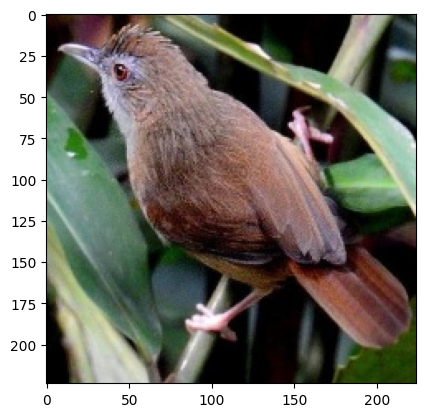

In [17]:
def show_example(img, label):
    print('Label: ', test_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img)

show_example(*test_dataset[0])

In [25]:
correct = []

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in test_loader.dataset.classes]).to(device)
for image, class_id in test_loader.dataset:
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity[0].topk(1)

        cls = test_loader.dataset.classes[class_id]
        pred = test_loader.dataset.classes[indices]
        print(cls, pred)
        if pred == cls:
            correct.append(1)
        else:
            correct.append(0)

print('accuracy on all is : ' + str(sum(correct)/len(correct)))

ABBOTTS BABBLER ABBOTTS BABBLER
ABBOTTS BABBLER FASCIATED WREN
ABBOTTS BABBLER ABBOTTS BABBLER
ABBOTTS BABBLER ABBOTTS BABBLER
ABBOTTS BABBLER ABBOTTS BABBLER
ABBOTTS BOOBY MASKED BOOBY
ABBOTTS BOOBY PALM NUT VULTURE
ABBOTTS BOOBY ABBOTTS BOOBY
ABBOTTS BOOBY ABBOTTS BOOBY
ABBOTTS BOOBY ABBOTTS BOOBY
ABYSSINIAN GROUND HORNBILL ABYSSINIAN GROUND HORNBILL
ABYSSINIAN GROUND HORNBILL ABYSSINIAN GROUND HORNBILL
ABYSSINIAN GROUND HORNBILL ABYSSINIAN GROUND HORNBILL
ABYSSINIAN GROUND HORNBILL CRESTED COUA
ABYSSINIAN GROUND HORNBILL ABYSSINIAN GROUND HORNBILL
AFRICAN CROWNED CRANE AFRICAN CROWNED CRANE
AFRICAN CROWNED CRANE AFRICAN CROWNED CRANE
AFRICAN CROWNED CRANE BLACK COCKATO
AFRICAN CROWNED CRANE AFRICAN CROWNED CRANE
AFRICAN CROWNED CRANE AFRICAN CROWNED CRANE
AFRICAN EMERALD CUCKOO AFRICAN EMERALD CUCKOO
AFRICAN EMERALD CUCKOO AFRICAN EMERALD CUCKOO
AFRICAN EMERALD CUCKOO EMERALD TANAGER
AFRICAN EMERALD CUCKOO AFRICAN EMERALD CUCKOO
AFRICAN EMERALD CUCKOO AFRICAN EMERALD CUCKOO
AFRICAN 